In [177]:
from typing import Any

from sklearn.model_selection import train_test_split
from aivolved.path import get_image_sources, directory_from_files

DATA_PATH = "data/soap/soap-80-20-20/"


def split_dataset(src: str, dst: str, label: str) -> None:
    sources = get_image_sources(f"{src}/{label}")
    train, test = train_test_split(sources, test_size=0.2)
    train, val = train_test_split(train, test_size=0.2)

    directory_from_files(f"{dst}/train/{label}", train)
    directory_from_files(f"{dst}/test/{label}", test)
    directory_from_files(f"{dst}/val/{label}", val)


split_dataset("data/soap/", DATA_PATH, label="defects")
split_dataset("data/soap/", DATA_PATH, label="non_defects")


100%|██████████| 87/87 [00:00<00:00, 3684.08it/s]

100%|██████████| 28/28 [00:00<00:00, 4909.52it/s]

100%|██████████| 22/22 [00:00<00:00, 4600.85it/s]

100%|██████████| 670/670 [00:00<00:00, 747.43it/s]

100%|██████████| 210/210 [00:00<00:00, 771.56it/s]

100%|██████████| 168/168 [00:00<00:00, 750.05it/s]


In [178]:
import torch
import torchvision

import numpy as np

train_dataset = torchvision.datasets.ImageFolder(
    DATA_PATH + "train",
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
    ])
)

data = np.array([np.array(img) for img, _ in train_dataset])
mean = data.mean(axis=(0, 1, 2)) / 255
mean

array([0.24232754, 0.29568848, 0.3936678 ])

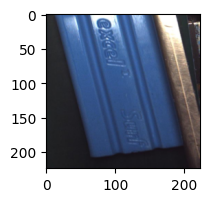

In [179]:
# sanity check

import matplotlib.pyplot as plt
plt.figure(figsize=(2, 2))
plt.imshow(np.array(train_dataset[0][0]))

In [237]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.AutoAugment(policy=torchvision.transforms.AutoAugmentPolicy.CIFAR10),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, stdev)
])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean, stdev)
])

train_dataset = torchvision.datasets.ImageFolder(DATA_PATH + "train", transform=train_transforms)
valid_dataset = torchvision.datasets.ImageFolder(DATA_PATH + "val", transform=train_transforms)
test_dataset = torchvision.datasets.ImageFolder(DATA_PATH + "test", transform=valid_transforms)
train_dataset

Dataset ImageFolder
    Number of datapoints: 757
    Root location: data/soap/soap-80-20-20/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               AutoAugment(policy=AutoAugmentPolicy.CIFAR10, fill=None)
               ToTensor()
               Normalize(mean=[0.24232754 0.29568848 0.3936678 ], std=0.18121950328350067)
           )

In [261]:
from torch.utils.data import DataLoader

WORKERS = 8

train_dataloader = DataLoader(train_dataset, batch_size=128, num_workers=WORKERS, pin_memory=True, shuffle=True, persistent_workers=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=256, num_workers=WORKERS, pin_memory=True, persistent_workers=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), num_workers=WORKERS, persistent_workers=True)

In [254]:
import lightning as pl


# define the LightningModule
class SoapBinaryClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.resnet = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT)
        self.criterion = torch.nn.CrossEntropyLoss()
        
        self.resnet.fc = torch.nn.Linear(self.resnet.fc.in_features, 2)
        torch.nn.init.xavier_uniform_(self.resnet.fc.weight)
    
    def forward(self, x):
        return self.resnet(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        
        loss = self.criterion(y_hat, y)
        acc = 100 * (torch.argmax(y_hat, dim=1) == y).sum() / len(x)
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.criterion(y_hat, y)
        acc = 100 * (torch.argmax(y_hat, dim=1) == y).sum() / len(x)
        
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        
        loss = self.criterion(y_hat, y)
        acc = 100 * (torch.argmax(y_hat, dim=1) == y).sum() / len(x)
        
        print(f"Test loss: {loss:.4f}")
        print(f"Test accuracy: {acc:.2f}%")

    def configure_optimizers(self):
        lr = 1e-5
        weight_decay = 5e-4
        
        params_1x = [param for name, param in self.resnet.named_parameters() if "fc" not in str(name)]
        optimizer = torch.optim.Adam([{"params": params_1x}, {"params": net.fc.parameters(), "lr": lr*10}], lr=lr, weight_decay=weight_decay)
        return optimizer


In [255]:
device = "mps"

model = SoapBinaryClassifier()
trainer = pl.Trainer(max_epochs=3, log_every_n_steps=1)
trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | resnet    | ResNet           | 21.3 M | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.143    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [262]:
trainer.test(model, dataloaders=test_dataloader)

Testing: |          | 0/? [00:00<?, ?it/s]

Test loss: 0.0202
Test accuracy: 100.00%


[{}]